# Desafio de Análise de Dados - Impulso-GOV

## Cenário

Apresentar informações sobre o estado de um município, com relação à COVID-19, a um gestor público, de forma que ele tenha informações suficientes para tomar decisões estratégicas. Para isso serão utilizados dados de indicadores já presentes no [FarolCovid](https://farolcovid.coronacidades.org/), além de outros indicadores que serão calculados aqui.

## Possíveis decisões da gestão

Ao lado de medidas educativas e humanitárias, algumas das principais medidas que um gestor de munício poderia tomar relativas ao combate à COVID-19 seriam:

1. Imposição de confinamento
2. Aquisição de mais testes
3. Controle da abertura de setores do comércio
4. Rigidez no controle de entrada de pessoas no munícipio

No Farol, acredito que indicadores relacionados as primeiras três decisões já estão muito bem calculados e apresentados. Então, no sentido de realizar uma análise mais útil, farei uma apresentação dos dados mais focada na quarta decisão **"Rigidez no controle de entrada de pessoas no munícipio"**, através de uma comparação facilitada entre municípios próximos fisicamente ao de interesse.

## Comparação com municípios próximos

### Lendo e preparando dados do FarolCovid

In [1]:
import pandas as pd


df = pd.read_csv('http://datasource.coronacidades.org/br/cities/farolcovid/main')

# Nessa análise, faremos quase todas as buscas por estado e cidade, então utilizá-los
# como índice para melhor performance
df.set_index(['state_id', 'city_name'], inplace=True)
df.sort_index(inplace=True)

### Preparando funções de cálculos geográficos

Serão analisados grupos de municípios delimitados pela região geográfica, utilizando para isso informações de suas coordenas. Logo, a **proximidade será medida em linha reta**, num raio predeterminado posteriomente, **em quilômetros**. Nessa seção serão implementadas as funções que facilitarão essa tarefa, utilizando como auxílio os dados de coordenadas disponibilizados neste [repositório](https://github.com/kelvins/Municipios-Brasileiros).

In [2]:
import pandas as pd
from geopy.distance import distance  # Para converter de coordenadas para quilômetros


df_states = pd.read_csv('https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/master/csv/estados.csv')
stateabbr_to_code = df_states.set_index('codigo_uf')['uf'].to_dict()  # Útil para transformações do código IBGE do estado para sua sigla

# Preparando DataFrame de coordenadas dos municípios utilizando a sigla do estado ao invés de código IBGE 
df_geo = pd.read_csv('https://raw.githubusercontent.com/kelvins/Municipios-Brasileiros/master/csv/municipios.csv')
df_geo['uf'] = df_geo['codigo_uf'].map(stateabbr_to_code)
df_geo.pop('codigo_uf')

# Utilizando estado e nome da cidade como índice, da mesma forma que no DataFrame principal
df_geo.set_index(['uf', 'nome'], inplace=True)
df_geo.sort_index(inplace=True)


# Desempenho pode ainda ser melhorado nessa função, utilizando um dicionário com informações dos estados
# que fazem fronteiras e com memoization. Mas não é importante agora.
def get_distances(state_abbr, city_name):
    '''
    Return distances from all Brazilian cities to a chosen one. 
    '''
    city = df_geo.loc[state_abbr, city_name]
    city_coords = city[['latitude', 'longitude']]

    def get_distance(row):
        this_coords = row[['latitude', 'longitude']]
        return distance(city_coords, this_coords).km
        
    distances = df_geo.apply(get_distance, axis='columns')
    distances.sort_values(inplace=True)
    
    return distances.rename('distance')


def get_nearby_cities(state_abbr, city_name, radius_km):
    """ Returns cities closer than 'radius_km' from a chosen one.  """
    
    distances = get_distances(state_abbr, city_name)
    distances = distances[distances <= radius_km]
    
    return distances.index

### Escolhendo cidade e raio de análise

In [3]:
state, city = 'MT', 'Barra do Garças'  # A cidade escolhida para a análise
radius_km = 100  # Cidades dentro desse raio, em km, em linha reta, serão consideradas na análise

nearby_cities = get_nearby_cities(state, city, radius_km)
nearby_cities  # Cidades dentro do raio especificado, a partir da escolhida

MultiIndex([('MT',        'Barra do Garças'),
            ('GO',              'Aragarças'),
            ('MT',     'Pontal do Araguaia'),
            ('GO',    'Bom Jardim de Goiás'),
            ('GO',                 'Baliza'),
            ('MT',              'Torixoréu'),
            ('MT',             'Araguaiana'),
            ('MT',       'General Carneiro'),
            ('GO',               'Piranhas'),
            ('MT',          'Ribeirãozinho'),
            ('GO',            'Doverlândia'),
            ('GO', 'Montes Claros de Goiás'),
            ('GO',             'Arenópolis')],
           names=['uf', 'nome'])

### Coletando dados de interese do DataFrame e colocando em estrutura de dados conveniente para plotagem

In [4]:
import numpy as np
from collections import defaultdict


def get_city_name(state, city):
    ''' Get formatted name for the city'''
    return f'{city} - {state}'


def get_city_infos(state, city):
    ''' Returns information (the chosen features) about the cities'''
    city_row = df.loc[state, city]

    return [
        ('contagious_rate', city_row['rt_10days_ago_avg']),
        ('isolation', city_row['inloco_today_7days_avg']),
        ('active_cases', city_row['active_cases']),
        ('population', city_row['population']),
    ]

# Títulos descritivos das features, serão utilizados como legenda
feature_to_title = {
    'active_cases': 'Casos Ativos',
    'contagious_rate': 'Ritmo de Contágio (Media última semana)',
    'isolation': 'Taxa de Isolamento (Média última semana)',
    'population': 'População (2019)',
}

# Irá conter os nomes e valores das features para plotagem
cities_infos = defaultdict(list)

for city_state in nearby_cities:
    try:
        infos = get_city_infos(*city_state)
    except KeyError:
        print(f'=> Cidade {get_city_name(*city_state)} não econtrada nos dados!')
        continue
        
    for name, value in get_city_infos(*city_state):
        cities_infos[name].append(value)
        
for name, values in cities_infos.items():
    cities_infos[name] = np.asarray(values)  # Convertando listas para array, para realização de operações vetorizadas
    cities_infos[name] = np.nan_to_num(cities_infos[name])  # Para plotagem, valores faltantes serão plotados como 0 (invisíveis, nesse caso)
    
cities = [get_city_name(*state_city) for state_city in nearby_cities]  # Nomes formatados das cidades
cities_infos  # Dados das cidades próximas

defaultdict(list,
            {'contagious_rate': array([0.        , 1.15428571, 0.        , 1.02285714, 0.        ,
                    0.        , 0.        , 0.        , 1.03714286, 0.        ,
                    0.        , 0.        , 0.        ]),
             'isolation': array([0.4047585 , 0.38191561, 0.33950196, 0.        , 0.        ,
                    0.        , 0.        , 0.        , 0.3441966 , 0.        ,
                    0.        , 0.41892045, 0.        ]),
             'active_cases': array([1.343e+03, 1.160e+02, 9.100e+01, 1.600e+01, 1.000e+00, 3.000e+01,
                    2.300e+01, 4.900e+01, 3.600e+01, 0.000e+00, 1.000e+00, 3.400e+01,
                    1.000e+00]),
             'population': array([61012, 20118,  6711,  8841,  5138,  3609,  3100,  5540, 10385,
                     2405,  7322,  8055,  2612])})

### Gerando feature(s) derivadas (das retiradas diretamente do Farol)

In [5]:
# Define escala do dado que será plotado. Ex: 1 infectado a cada 200 habitantes
INFECTED_GROUP = 200
    
# Títulos das features derivadas das anteriores, mantendo separado suas definições propositalmente    
new_titles = {
    'infected_rate': f'Infectados (a cada {INFECTED_GROUP} habitantes)'  # Aproximadamente, porque é a população de 2019
}
feature_to_title.update(new_titles)
    
# Calcula taxa de infectados, pois a escala se aproxima melhor das outras features do que utilizando "casos ativos" e "população" diretamente,
#   então a visualização se tornará melhor
cities_infos['infected_rate'] = cities_infos['active_cases'] / cities_infos['population'] * INFECTED_GROUP
cities_infos.pop('active_cases')
_ = cities_infos.pop('population')

### Verificando intervalos e limitações do dado

In [6]:
import numpy as np


# Checando intervalos de valores das features, devem ser próximos para gerar uma melhor experiência ao ser ler o gráfico.
#   Poderia também usar escala logarítmica ou outro tipo de normalização, mas, com a abordagem atual, o entedimento do gráfico
#   se torna de mais fácil a qualquer tipo de gestor
print('Intervalos dos valores:')
for name, values in cities_infos.items():
    values = np.nan_to_num(values)
    print(f'\t{name} interval: [{values.min()}, {values.max()}]')
    
print()
print('Cidades comparadas:\n\t', ', '.join(cities))  # Checando novamente a lista das cidades que serão comparadas

print()
print('Duplicações no índice:')
num_duplications = df.index.shape[0] - df.index.drop_duplicates().shape[0] 
print(f'\tO DataFrame principal possui um total de {num_duplications} em seu índice')

print()
columns = ['active_cases', 'population', 'rt_10days_ago_avg', 'inloco_today_7days_avg']
total_columns = df[columns].shape[0]
num_missing = total_columns - df[columns].dropna().shape[0]
print(f'O DataFrame principal possui um total de {num_missing} valores faltantes de um total de {total_columns} para as colunas de interesse:')
print('\t' + ', '.join(columns))

# Número alto de valores faltantes considerando a união das colunas, porém esse problema não será tão relevante para esta análise, isso só limitará alguns tipos
#   de análises em algumas regiões especificas. Com a análise que será feita, ainda poderão ser avaliadas parcialmente algumas regiões e completamente outras.

Intervalos dos valores:
	contagious_rate interval: [0.0, 1.1542857142857137]
	isolation interval: [0.0, 0.4189204472468333]
	infected_rate interval: [0.0, 4.402412640136367]

Cidades comparadas:
	 Barra do Garças - MT, Aragarças - GO, Pontal do Araguaia - MT, Bom Jardim de Goiás - GO, Baliza - GO, Torixoréu - MT, Araguaiana - MT, General Carneiro - MT, Piranhas - GO, Ribeirãozinho - MT, Doverlândia - GO, Montes Claros de Goiás - GO, Arenópolis - GO

Duplicações no índice:
	O DataFrame principal possui um total de 0 em seu índice

O DataFrame principal possui um total de 2664 valores faltantes de um total de 5570 para as colunas de interesse:
	active_cases, population, rt_10days_ago_avg, inloco_today_7days_avg


### Plotando visualização geral da situação dos municípios próximos

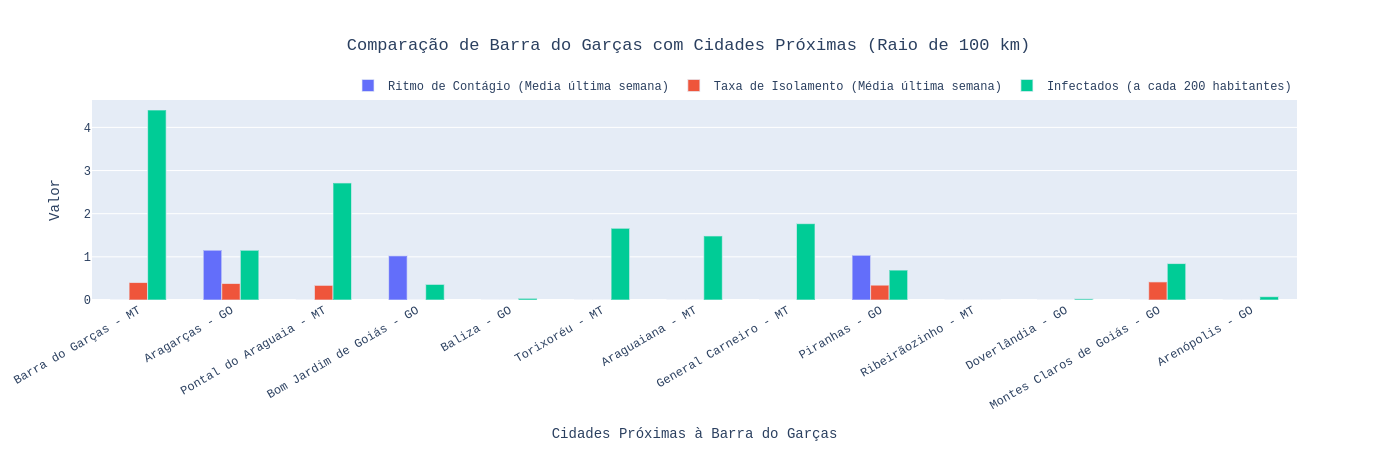

state_id  city_name             
GO        Aragarças                 20118
          Arenópolis                 2612
          Baliza                     5138
          Bom Jardim de Goiás        8841
          Doverlândia                7322
          Montes Claros de Goiás     8055
          Piranhas                  10385
MT        Araguaiana                 3100
          Barra do Garças           61012
          General Carneiro           5540
          Pontal do Araguaia         6711
          Ribeirãozinho              2405
          Torixoréu                  3609
Name: population, dtype: int64

In [7]:
import plotly
import plotly.graph_objects as go
from plotly.offline import init_notebook_mode


init_notebook_mode(connected=True)

fig = go.Figure()

for name, values in cities_infos.items():
    fig.add_trace(go.Bar(
        x=cities,
        y=values,
        name=feature_to_title[name],
    ),
)

fig.update_layout(
    title=f'Comparação de {city} com Cidades Próximas (Raio de {radius_km} km)',
    title_x=0.5,
    barmode='group',
    bargap=0.4,
    xaxis_tickangle=-30,
    xaxis_title=f'Cidades Próximas à {city}',
    yaxis_title='Valor',
    font=dict(
        family="Courier New, monospace",
        size=12,
    ),
    legend=dict(
        orientation="h",
        yanchor="bottom",
        xanchor="right",
        y=1,
        x=1
    ),
)

fig.show()

# Adicionando visualização da população absoluta (2019) de cada cidade próxima
df[df.index.isin(nearby_cities)]['population']

### Análise

Aqui a cidade escolhida foi **Barra do Garças - Mato Grosso (MT)**. Barra do Garças e redondezas formam uma região interessante de ser análisada por estar com níveis consideráveis dos indicadores escolhidos e também está localizada na divisa entre os estados de Goiás (GO) e Mato Grosso (MT).

Nesse ponto, vale comentar novamente que o critério utilizado para o agrupamento das cidades foi a distância física. Talvez o palpite de comparação mais imediato seria o de agrupar por regiões do SUS, mas as regiões do SUS não representam diretamente o movimento dos cidadãos ao escolherem um hospital, e mais relevante ainda, cada cidade pertence a apenas uma região (como pode ser checado no § 3º [desta resolução](https://bvsms.saude.gov.br/bvs/saudelegis/cit/2011/res0001_29_09_2011.html#:~:text=Estabelece%20diretrizes%20gerais%20para%20a,de%201990%2C%20e%20o%20art.) do Ministério da Saúde), ou seja, **duas cidades podem ser vizinhas e não pertecerem a mesma região do SUS.**

Voltando a análise, pode-se observar que nenhum município do MT nessa região possui informações de ritmo de contágio, mesmo estando bem próximos de outros que as têm (Aragarças, no Goiás, é separada de Barra do Garças por uma ponte apenas).

Outro fato digno de nota, é que mesmo com uma maior de taxa de isolamento, Barra do Garças possui uma **taxa de infectados por habitante aproximadamente 60% maior** do que sua vizinha, Aragarças. Isso provavelmente tem forte influência do volume de sua população, **aproximadamente 3x superior**. Mas também pode ter como fatores envolvidos diferentes políticas públicas entre os estados, MT e GO, ou um ritmo de evolução diferente da doença, o que poderia ser checado com a realização de uma análise temporal dos dados.

Com as informações aqui apresentadas, um gestor poderia facilmente comparar o estado da doença em municípios próximos ao seu e tomar medidas de controle de trafêgo em seus limites, como aferição da temperaturas, imposição de quarentena a novos visitantes e até, talvez, uma restrição mais rígida, como o impedimento da entrada de um visitante. Uma limitação dessa abordagem seria a checagem de rotas movimentadas entre municípios distantes, por exemplo, por avião, trem ou barco.